In [336]:
#import all packages needed, define file import

import math

import networkx as nx

import geopandas as gpd

import json
from networkx.readwrite import json_graph

import gurobipy as gp
from gurobipy import GRB

from gerrychain import Graph

def read_graph_from_json(json_file):
    with open(json_file) as f:
        data = json.load(f)
    return json_graph.adjacency_graph(data) 

In [337]:
#read in the .shp and json file information for MT
shp_filename = 'MT_county.shp'
df = gpd.read_file( shp_filename ) 
json_filename = 'MT_county.json'
G_Montana = read_graph_from_json( json_filename )

#show nodes and verticies for visual confirmation
print("The graph G_Montana contains:")
print()
print("The nodes:")
print(G_Montana.nodes)
print()
print("And edges:")
print(G_Montana.edges)

The graph G_Montana contains:

The nodes:
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55]

And edges:
[(0, 50), (0, 28), (0, 43), (0, 46), (1, 9), (1, 21), (1, 27), (1, 44), (1, 25), (2, 26), (2, 35), (2, 23), (2, 54), (2, 3), (3, 54), (4, 29), (4, 31), (4, 13), (4, 35), (5, 21), (5, 49), (5, 44), (5, 16), (5, 38), (5, 48), (6, 7), (6, 20), (6, 17), (6, 15), (7, 16), (7, 38), (7, 20), (8, 18), (8, 45), (8, 27), (8, 41), (8, 30), (8, 55), (9, 14), (9, 18), (9, 27), (10, 47), (10, 51), (10, 22), (11, 55), (11, 42), (11, 34), (11, 24), (12, 30), (12, 43), (12, 55), (12, 53), (12, 42), (13, 29), (13, 28), (13, 35), (13, 46), (13, 54), (14, 50), (14, 18), (14, 45), (14, 43), (15, 17), (15, 32), (15, 36), (15, 37), (16, 49), (16, 38), (17, 38), (17, 20), (17, 48), (17, 32), (18, 45), (18, 27), (19, 46), (19, 53), (19, 42), (19,

In [338]:
#prints, for each node of the graph, its node #, county name, and population

for node in G_Montana.nodes:
    county_name = G_Montana.nodes[node]['NAME20']
    county_population = G_Montana.nodes[node]['P0010001']
    G_Montana.nodes[node]['TOTPOP'] = county_population
    print("Node",node,"represents",county_name,"County, pop:",county_population)

Node 0 represents Broadwater County, pop: 6774
Node 1 represents Big Horn County, pop: 13124
Node 2 represents Sanders County, pop: 12400
Node 3 represents Lincoln County, pop: 19677
Node 4 represents Granite County, pop: 3309
Node 5 represents Custer County, pop: 11867
Node 6 represents Richland County, pop: 11491
Node 7 represents Wibaux County, pop: 937
Node 8 represents Golden Valley County, pop: 823
Node 9 represents Carbon County, pop: 10473
Node 10 represents Toole County, pop: 4971
Node 11 represents Blaine County, pop: 7044
Node 12 represents Judith Basin County, pop: 2023
Node 13 represents Powell County, pop: 6946
Node 14 represents Park County, pop: 17191
Node 15 represents Roosevelt County, pop: 10794
Node 16 represents Fallon County, pop: 3049
Node 17 represents McCone County, pop: 1729
Node 18 represents Stillwater County, pop: 8963
Node 19 represents Teton County, pop: 6226
Node 20 represents Dawson County, pop: 8940
Node 21 represents Powder River County, pop: 1694
Nod

In [339]:
##Dispaly all of the neighbors for a given county node
#
#for i in range(node):
#    print("County",i,"touches:",list(G_Montana.neighbors(i) ) )

In [340]:
##prints a list of all touching counties in readable format for verification
#
#for i in range(node):
#    print(G_Montana.nodes[i]["NAME20"],"county touches counties:",end="")
#    for n in (G_Montana.neighbors(i)):
#       print(",",G_Montana.nodes[n]["NAME20"],end="")
#    print()

In [341]:
#nx.draw(G_Montana, with_labels=True)

In [342]:
## perliminary districting map example. 
## changing the value currently set to '5' in the 'district' variable adjusts which counties are highlighted as the county = to node 5 and all of its neighbors 
#
#
#district = [ 5 ] + [ j for j in G_Montana.neighbors(5) ]
#district_geoids = [ G_Montana.nodes[i]["GEOID20"] for i in district ]
#
## For nodes in district, set their 'selected' values to 1. Set others to zero.
#df['selected'] = [1 if df['GEOID20'][u] in district_geoids else 0 for u in G_Montana.nodes]
#            
#my_figure = df.plot(column='selected').get_figure()

In [367]:
## For each node, print the node #, county name, and its population
#for node in G_Montana.nodes:
#    county_name = G_Montana.nodes[node]['NAME20']
#    county_population = G_Montana.nodes[node]['P0010001']
#    G_Montana.nodes[node]['TOTPOP'] = county_population   #reassign the population identifier within the dictionary to TOTPOP
#    print("Node",node,"represents",county_name,"County, which had a population of",county_population,"in the 2020 census.")

In [362]:
# start of optimization model

#checklist:
## [x] set deviation to appropriate level
## [] build in compactness
## [] set other parameters?
## [] set proper anchor locations?
## [] source minimum district population? Why is it only two districts?

# create model 
m = gp.Model()

# define variables to be used within the model
k = 2 #----------------------------------------------------------# desired number of districts
x = m.addVars( G_Montana.nodes, k, vtype=GRB.BINARY ) #----------# x[i,j] = 1 when county i is assigned to district j
y = m.addVars( G_Montana.edges, vtype=GRB.BINARY ) #-------------# y[u,v] = 1 when edge {u,v} is cut
r = m.addVars( G_Montana.nodes, k, vtype=GRB.BINARY ) #----------# Add root variables: r[i,j] equals 1 if node i is the "root" of district j
deviation = 0.0010 #---------------------------------------------# lecture video says to keep this level. 2020 %range deviation of population between districts is 6.98%: https://www.ncsl.org/elections-and-campaigns/2020-redistricting-deviation-table
total_population = sum( G_Montana.nodes[i]['TOTPOP'] for i in G_Montana.nodes ) # extracts the sum of all county populations from the original file
ideal_population = total_population / k #------------------------# gives the unadjusted population per district
L = math.ceil( ( 1 - (deviation / 2 )) * ideal_population ) #----# next highest integer of 1 minus the deviation percentage from the ideal population number
U = math.floor( ( 1 + (deviation / 2 )) * ideal_population ) #---# next lowest integer of the 1 plus the deviation percentage from the ideal population number
percent_of_total = round((((U-L)*k)/total_population)*100,2) #---# backs out the percent of the total population as a checksum for our inputs
r[46,0].LB = 1 #-------------------------------------------------# fix [53] county as root of district 0 (cascade while testing)
r[48,1].LB = 1 #-------------------------------------------------# fix [48] county as root of district 1 (garfield while testing)
# Add flow variables: f[u,v] = amount of flow sent across arc uv, Flows are sent across arcs of the directed version of G which we call DG 
DG = nx.DiGraph(G_Montana) #-------------------------------------# directed version of G
f = m.addVars( DG.edges ) #--------------------------------------# assigns all weights on edges based on DG??
M = G_Montana.number_of_nodes() - k + 1 #------------------------# The big-M proposed by Hojny et al.

#do a double take
if(percent_of_total == (deviation*100)):
    a="  Great!! This matches our input!!"
else:a="  This math is not mathing. :("

# Garbage in??
print("The total population of MT in the 2020 census is",total_population)
print("The deviation range is set to",deviation*100,"%")
print("This gives:")
print(" - The Lower district population bound to be:",L)
print(" - The Upper district population bound to be:",U)
print(" - The absolute district population range to be:",(U-L)*k)
print(" - For a total of",k,"districts")
print()
print("This is",percent_of_total,"% of",total_population,a)
#print(math.ceil(1.2))  #demo the .ceil operator - returns the next highest integer
#print(math.floor(1.8)) #demo the .floor operator - returns the next lowest integer

The total population of MT in the 2020 census is 1084225
The deviation range is set to 0.1 %
This gives:
 - The Lower district population bound to be: 541842
 - The Upper district population bound to be: 542383
 - The absolute district population range to be: 1082
 - For a total of 2 districts

This is 0.1 % of 1084225   Great!! This matches our input!!


In [363]:
# objective is to minimize cut edges
m.setObjective( gp.quicksum( y[u,v] for u,v in G_Montana.edges ), GRB.MINIMIZE )

# add constraints saying that each county i is assigned to one district
m.addConstrs( gp.quicksum( x[i,j] for j in range(k) ) == 1 for i in G_Montana.nodes )

# add constraints saying that each district has a population at least L and at most U.
m.addConstrs( gp.quicksum( G_Montana.nodes[i]['TOTPOP'] * x[i,j] for i in G_Montana.nodes ) >= L for j in range(k) )
m.addConstrs( gp.quicksum( G_Montana.nodes[i]['TOTPOP'] * x[i,j] for i in G_Montana.nodes ) <= U for j in range(k) )

# add constraints saying that edge {u,v} is cut if u is assigned to district j but v is not.
m.addConstrs( x[u,j] - x[v,j] <= y[u,v] for u,v in G_Montana.edges for j in range(k) )

# Each district j should have one root
m.addConstrs( gp.quicksum( r[i,j] for i in G_Montana.nodes ) == 1 for j in range(k) )

# If node i is not assigned to district j, then it cannot be its root
m.addConstrs( r[i,j] <= x[i,j] for i in G_Montana.nodes for j in range(k) ) 

# if not a root, consume some flow.
# if a root, only send out (so much) flow.
m.addConstrs( gp.quicksum( f[j,i] - f[i,j] for j in G_Montana.neighbors(i) ) 
             >= 1 - M * gp.quicksum( r[i,j] for j in range(k) ) for i in G_Montana.nodes )

# do not send flow across cut edges
m.addConstrs( f[i,j] + f[j,i] <= M * ( 1 - y[i,j] ) for i,j in G_Montana.edges )

m.update()

In [364]:
# solve IP model

m.optimize()

Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (mac64[arm] - Darwin 20.6.0 20G165)

CPU model: Apple M1
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 644 rows, 638 columns and 2578 nonzeros
Model fingerprint: 0xc479a620
Variable types: 276 continuous, 362 integer (362 binary)
Coefficient statistics:
  Matrix range     [1e+00, 2e+05]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 5e+05]
Presolve removed 200 rows and 184 columns
Presolve time: 0.00s
Presolved: 444 rows, 454 columns, 1818 nonzeros
Variable types: 276 continuous, 178 integer (178 binary)

Root relaxation: objective 7.000000e+00, 209 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0    7.00000    0   45          -    7.00000      -     -    0s
     0     0    7.62555 

In [365]:
print("The number of cut edges is",m.objval)
print()

# retrieve the districts and their populations
districts = [ [i for i in G_Montana.nodes if x[i,j].x > 0.5] for j in range(k)]
district_counties = [ [ G_Montana.nodes[i]["NAME20"] for i in districts[j] ] for j in range(k)]
district_populations = [ sum(G_Montana.nodes[i]["TOTPOP"] for i in districts[j]) for j in range(k) ]

#validate that the districts we created are in fact connected. 
for district in range(k):
    print("Is district", district , "connected?", nx.is_connected( G_Montana.subgraph( district ) ) )
#print(districts[0])
#print(districts[1])
print()

# print district info in readable format
for j in range(k):
    print("District",j,"has population",district_populations[j],"and contains counties",district_counties[j])
    print("")

The number of cut edges is 15.0

Is district 0 connected? True
Is district 1 connected? True

District 0 has population 542094 and contains counties ['Sanders', 'Lincoln', 'Granite', 'Toole', 'Powell', 'Teton', 'Glacier', 'Lake', 'Mineral', 'Deer Lodge', 'Ravalli', 'Missoula', 'Lewis and Clark', 'Pondera', 'Liberty', 'Cascade', 'Flathead']

District 1 has population 542131 and contains counties ['Broadwater', 'Big Horn', 'Custer', 'Richland', 'Wibaux', 'Golden Valley', 'Carbon', 'Blaine', 'Judith Basin', 'Park', 'Roosevelt', 'Fallon', 'McCone', 'Stillwater', 'Dawson', 'Powder River', 'Hill', 'Treasure', 'Yellowstone', 'Jefferson', 'Wheatland', 'Valley', 'Petroleum', 'Phillips', 'Sheridan', 'Daniels', 'Prairie', 'Madison', 'Beaverhead', 'Musselshell', 'Chouteau', 'Meagher', 'Rosebud', 'Sweet Grass', 'Garfield', 'Carter', 'Gallatin', 'Silver Bow', 'Fergus']



The number of cut edges is 15.0

Is district 0 connected? True
Is district 1 connected? True

District 0 has a population of 542094
District 1 has a population of 542131
This is a range of 0.007 %


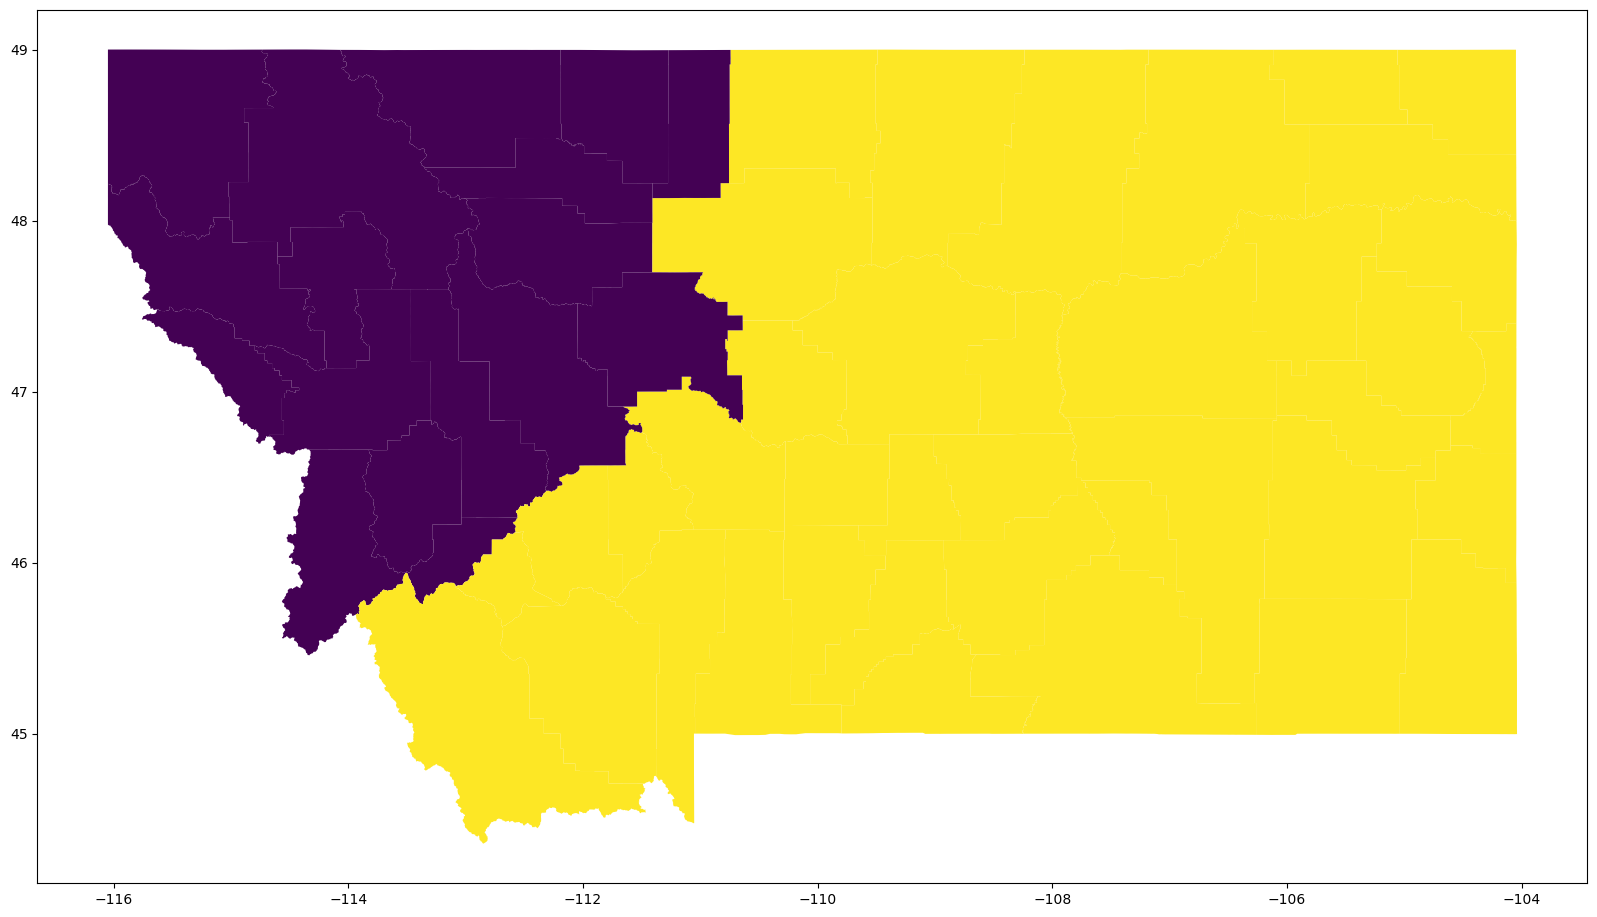

In [366]:
#compile results and generate district map

print("The number of cut edges is",m.objval)
print()

# retrieve the districts and their populations
districts = [ [i for i in G_Montana.nodes if x[i,j].x > 0.5] for j in range(k)]
district_counties = [ [ G_Montana.nodes[i]["NAME20"] for i in districts[j] ] for j in range(k)]
district_populations = [ sum(G_Montana.nodes[i]["TOTPOP"] for i in districts[j]) for j in range(k) ]
percent_difference = round(((abs(district_populations[0]-district_populations[1])*2)/total_population)*100,3)

#validate that the districts we created are in fact connected. 
for district in range(k):
    print("Is district", district , "connected?", nx.is_connected( G_Montana.subgraph( district ) ) )
#print(districts[0])
#print(districts[1])
print()

for i in range(k):
    print("District",i,"has a population of",district_populations[i])
print("This is a range of",percent_difference,"%")

# print district info in readable format
#for j in range(k):
#    print("District",j,"has population",district_populations[j],"and contains counties",district_counties[j])
#    print("")

assignment = [ -1 for i in G_Montana.nodes ]
labeling = { i : j for i in G_Montana.nodes for j in range(k) if x[i,j].x > 0.5 }

# Now add the assignments to a column of the dataframe and map it
node_with_this_geoid = { G_Montana.nodes[i]['GEOID20'] : i for i in G_Montana.nodes }

# pick a position u in the dataframe
for u in range(G_Montana.number_of_nodes()):
    
    geoid = df['GEOID20'][u]
    
    # what node in G has this geoid?
    i = node_with_this_geoid[geoid]
    
    # position u in the dataframe should be given
    # the same district # that county i has in 'labeling'
    assignment[u] = labeling[i]
    
# now add the assignments to a column of our dataframe and then map it
df['assignment'] = assignment

my_fig = df.plot(column='assignment',figsize=(20,30)).get_figure()